# Integration of CITE-seq and scRNA-seq data

Here we demonstrate how to integrate CITE-seq and scRNA-seq datasets with totalVI. The same principles here can be used to integrate CITE-seq datasets with different sets of measured proteins.

Uncomment the following lines in Google Colab in order to install `scvi-tools`:

In [1]:
# !pip install --quiet scvi-colab
# from scvi_colab import install

# install()

In [2]:
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import scanpy as sc
import scvi
import torch
from scipy.stats import pearsonr

## Imports and data loading

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Last run with scvi-tools version: 1.0.3


You can modify `save_dir` below to change where the data files for this tutorial are saved.

In [4]:
sc.set_figure_params(figsize=(4, 4))
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Here we focus on two CITE-seq datasets of peripheral blood mononuclear cells from 10x Genomics and used in the totalVI manuscript. We have already filtered these datasets for doublets and low-quality cells and genes.

The quality of totalVI's protein imputation is somewhat reliant on how well the datasets mix in the latent space. In other words, it's assumed here the datasets largely share the same cell subpopulations.

In [5]:
adata = scvi.data.pbmcs_10x_cite_seq(save_path=save_dir.name)

INFO     Downloading file at /tmp/tmpab2pma3s/pbmc_10k_protein_v3.h5ad                                             
Downloading...: 24938it [00:00, 100358.22it/s]                             
INFO     Downloading file at /tmp/tmpab2pma3s/pbmc_5k_protein_v3.h5ad                                              
Downloading...: 100%|██████████| 18295/18295.0 [00:00<00:00, 93679.78it/s]


/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [6]:
# batch 0 corresponds to dataset_10k, batch 1 corresponds to dataset_5k
batch = adata.obs.batch.values.ravel()
adata.obs.batch

index
AAACCCAAGATTGTGA-1    PBMC10k
AAACCCACATCGGTTA-1    PBMC10k
AAACCCAGTACCGCGT-1    PBMC10k
AAACCCAGTATCGAAA-1    PBMC10k
AAACCCAGTCGTCATA-1    PBMC10k
                       ...   
TTTGGTTGTACGAGTG-1     PBMC5k
TTTGTTGAGTTAACAG-1     PBMC5k
TTTGTTGCAGCACAAG-1     PBMC5k
TTTGTTGCAGTCTTCC-1     PBMC5k
TTTGTTGCATTGCCGG-1     PBMC5k
Name: batch, Length: 10849, dtype: object

Now we hold-out the proteins of the 5k dataset. To do so, we can replace all the values with 0s. We will store the original values to validate after training.

In [7]:
held_out_proteins = adata.obsm["protein_expression"][batch == "PBMC5k"].copy()
adata.obsm["protein_expression"].loc[batch == "PBMC5k"] = np.zeros_like(
    adata.obsm["protein_expression"][batch == "PBMC5k"]
)

In [8]:
sc.pp.highly_variable_genes(
    adata, batch_key="batch", flavor="seurat_v3", n_top_genes=4000, subset=True
)

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


```{important}
scvi-tools will automatically detect proteins as missing in a certain batch if the protein has 0 counts for each cell in the batch. In other words, to indicate a protein is missing in a certain batch, please set it to 0 for each cell.
```

In [9]:
scvi.model.TOTALVI.setup_anndata(
    adata, batch_key="batch", protein_expression_obsm_key="protein_expression"
)

INFO     Using column names from columns of adata.obsm['protein_expression']                                       
INFO     Found batches with missing protein expression                                                             


## Prepare and run model

In [10]:
model = scvi.model.TOTALVI(adata, latent_distribution="normal", n_layers_decoder=2)

INFO     Computing empirical prior initialization for protein background.                                          


/tmp/ipykernel_896225/3261033344.py:1: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.


In [11]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:306: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.


Epoch 371/400:  93%|█████████▎| 371/400 [03:16<00:15,  1.88it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.19e+3] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1215.448. Signaling Trainer to stop.


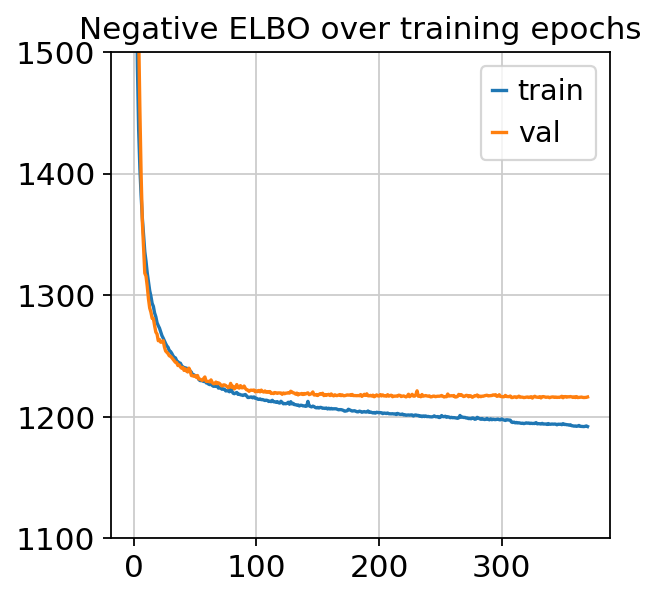

In [12]:
plt.plot(model.history["elbo_train"], label="train")
plt.plot(model.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
plt.ylim(1100, 1500)
plt.legend()

## Analyze outputs

Again, we rely on Scanpy.

In [13]:
TOTALVI_LATENT_KEY = "X_totalVI"
PROTEIN_FG_KEY = "protein_fg_prob"

adata.obsm[TOTALVI_LATENT_KEY] = model.get_latent_representation()
adata.obsm[PROTEIN_FG_KEY] = model.get_protein_foreground_probability(
    transform_batch="PBMC10k"
)

rna, protein = model.get_normalized_expression(
    transform_batch="PBMC10k", n_samples=25, return_mean=True
)

```{note}
`transform_batch` is a powerful parameter. Setting this allows one to predict the expression of cells as if they came from the inputted batch. In this case, we've observed protein expression in batch "PBMC10k" (batch categories from original adata object), but we have no protein expression in batch "PBMC5k". We'd like to take the cells of batch "PBMC5k" and make a counterfactual prediction: "What would the expression look like if my batch "PBMC5k" cells came from batch "PBMC10k"?"
```

In [14]:
protein.iloc[:5, :5]

CD3_TotalSeqB  CD4_TotalSeqB  CD8a_TotalSeqB  \
index                                                              
AAACCCAAGATTGTGA-1       8.730785     216.524780        0.259463   
AAACCCACATCGGTTA-1      28.873009     168.789185        1.665653   
AAACCCAGTACCGCGT-1       9.970943     364.649597        9.701180   
AAACCCAGTATCGAAA-1       2.309663       2.389102       25.858837   
AAACCCAGTCGTCATA-1       0.597749       0.102124       26.007139   

                    CD14_TotalSeqB  CD15_TotalSeqB  
index                                               
AAACCCAAGATTGTGA-1      864.060852      100.366814  
AAACCCACATCGGTTA-1      669.581726      102.217430  
AAACCCAGTACCGCGT-1     1251.663696      113.991188  
AAACCCAGTATCGAAA-1        0.051375      103.746170  
AAACCCAGTCGTCATA-1        0.014883       94.291405

```{important}
The following is for illustrative purposes. In the code blocks above, we have the denoised protein values for each cell. These values have the expected protein background component removed. However, to compare to the held out protein values, we must include both protein foreground and background. We recommend using the values above for downstream tasks.
```

In [15]:
_, protein_means = model.get_normalized_expression(
    n_samples=25,
    transform_batch="PBMC10k",
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

In [16]:
TOTALVI_CLUSTERS_KEY = "leiden_totalVI"

sc.pp.neighbors(adata, use_rep=TOTALVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added=TOTALVI_CLUSTERS_KEY)

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packag

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


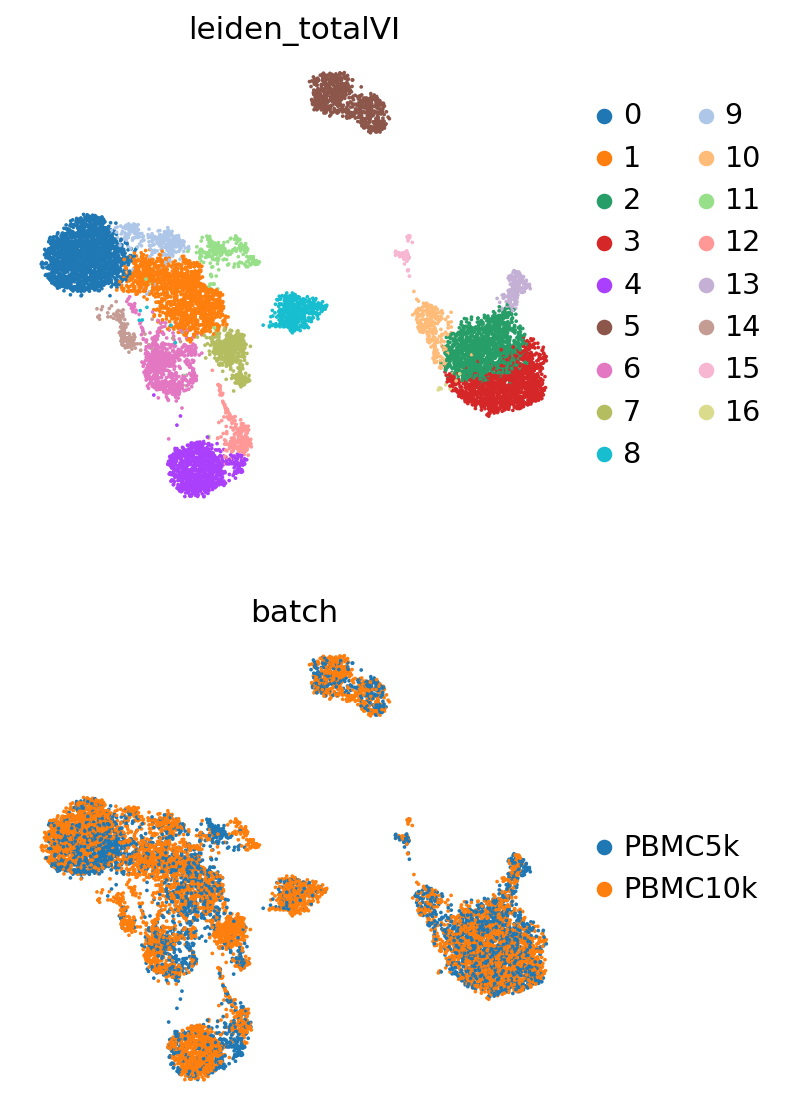

In [17]:
perm_inds = np.random.permutation(len(adata))
sc.pl.umap(
    adata[perm_inds],
    color=[TOTALVI_CLUSTERS_KEY, "batch"],
    ncols=1,
    frameon=False,
)

In [18]:
batch = adata.obs.batch.values.ravel()
combined_protein = np.concatenate(
    [adata.obsm["protein_expression"].values[batch == "PBMC10k"], held_out_proteins],
    axis=0,
)

# cleaner protein names
parsed_protein_names = [
    p.split("_")[0] for p in adata.obsm["protein_expression"].columns
]
for i, p in enumerate(parsed_protein_names):
    adata.obs[f"{p} imputed"] = protein_means.iloc[:, i]
    adata.obs[f"{p} observed"] = combined_protein[:, i]

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


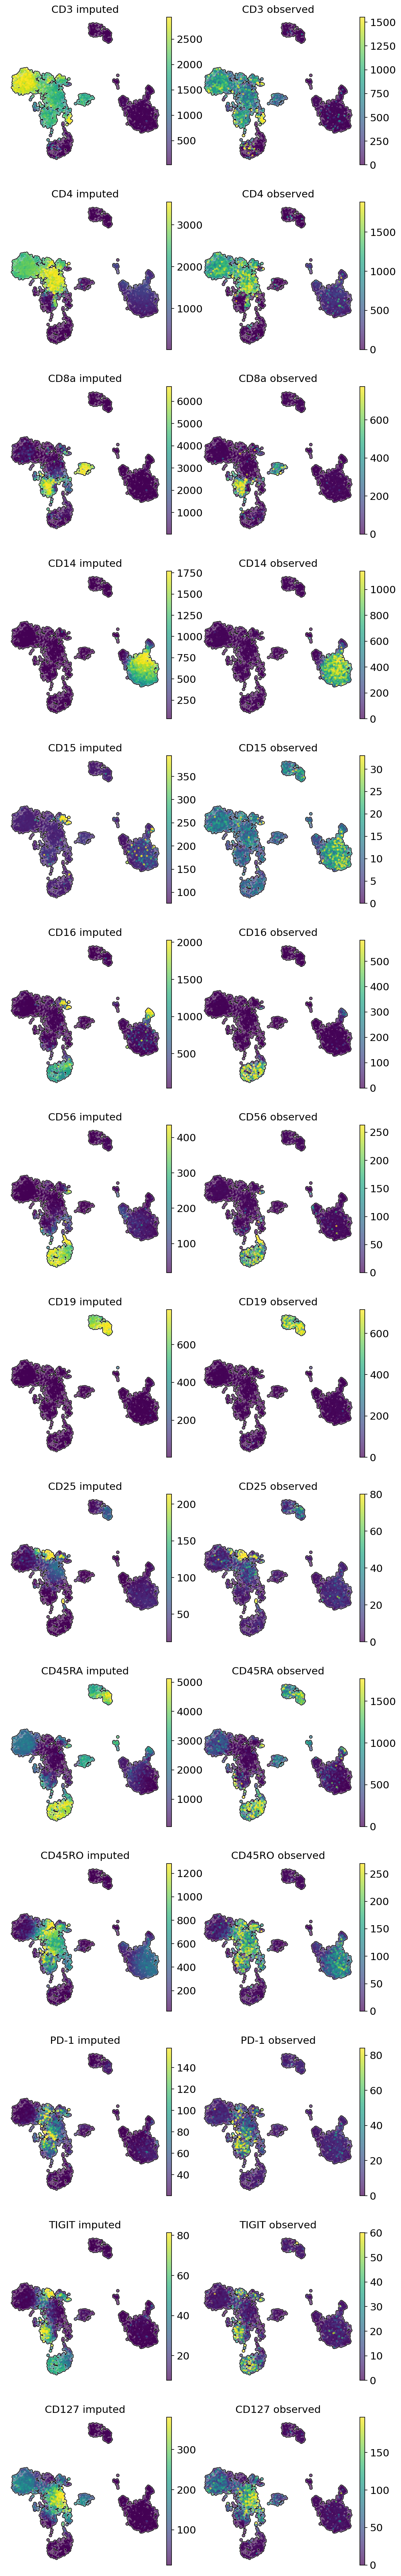

In [19]:
viz_keys = []
for p in parsed_protein_names:
    viz_keys.append(p + " imputed")
    viz_keys.append(p + " observed")

sc.pl.umap(
    adata[adata.obs.batch == "PBMC5k"],
    color=viz_keys,
    ncols=2,
    vmax="p99",
    frameon=False,
    add_outline=True,
    wspace=0.1,
)

## Imputed vs denoised correlations

In [20]:
imputed_pros = protein_means[batch == "PBMC5k"]
held_vs_denoised = pd.DataFrame()
held_vs_denoised["Observed (log)"] = np.log1p(held_out_proteins.values.ravel())
held_vs_denoised["Imputed (log)"] = np.log1p(imputed_pros.to_numpy().ravel())
protein_names_corrs = []
for i, p in enumerate(parsed_protein_names):
    protein_names_corrs.append(
        parsed_protein_names[i]
        + ": Corr="
        + str(
            np.round(
                pearsonr(held_out_proteins.values[:, i], imputed_pros.iloc[:, i])[0], 3
            )
        )
    )
held_vs_denoised["Protein"] = protein_names_corrs * len(held_out_proteins)
held_vs_denoised.head()

Observed (log)  Imputed (log)           Protein
0        3.258097       3.581262   CD3: Corr=0.788
1        5.105945       6.042910   CD4: Corr=0.869
2        2.833213       3.450558  CD8a: Corr=0.836
3        6.546785       7.202819  CD14: Corr=0.907
4        2.995732       4.784925  CD15: Corr=0.076

We notice that CD15 has a really low correlation (imputation accuracy). Recall that imputation involves a counterfactual query -- "what would the protein expression have been for these cells if they came from the PBMC10k dataset?" Thus, any technical issues with proteins in CD15 in PBMC10k will be reflected in the imputed values. It's the case here that CD15 was not captured as well in the PBMC10k dataset compared to the PBMC5k dataset.

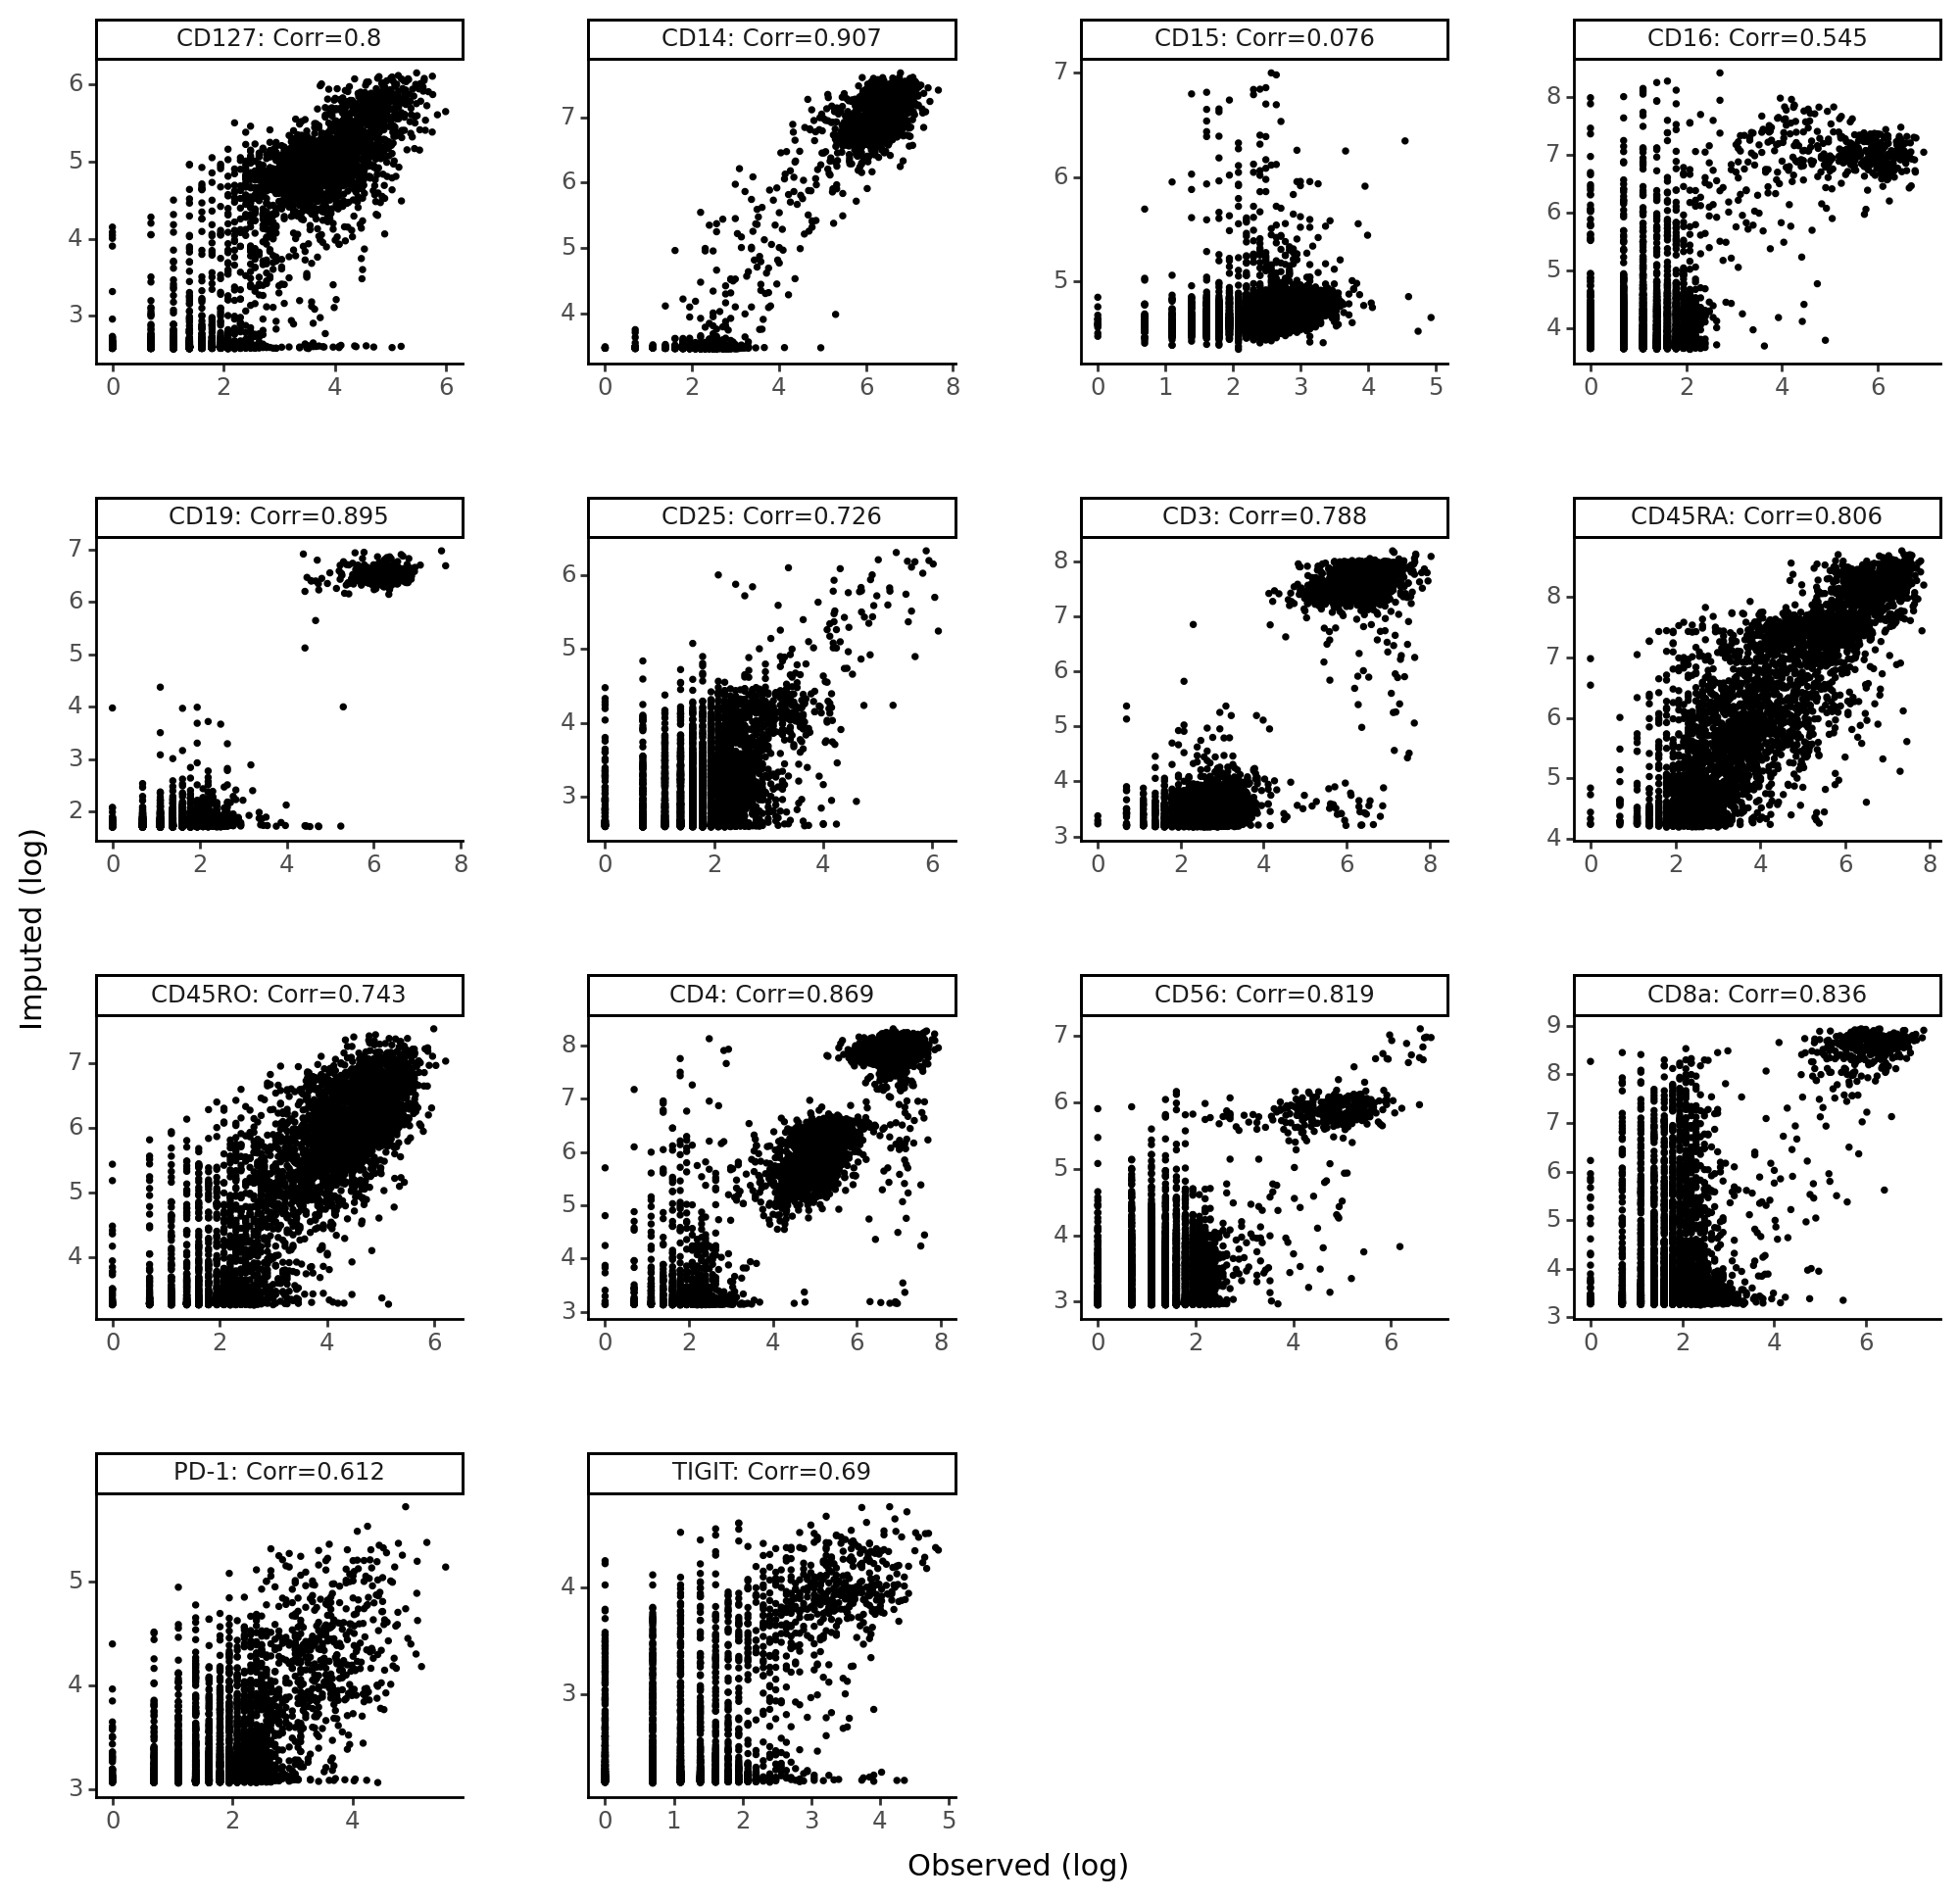

<Figure Size: (1000 x 1000)>

In [21]:
p9.theme_set(p9.theme_classic)
(
    p9.ggplot(held_vs_denoised, p9.aes("Observed (log)", "Imputed (log)"))
    + p9.geom_point(size=0.5)
    + p9.facet_wrap("~Protein", scales="free")
    + p9.theme(
        figure_size=(10, 10),
        panel_spacing=0.05,
    )
)

## Clean up

Uncomment the following line to remove all data files created in this tutorial:

In [22]:
# save_dir.cleanup()